# Unsupervised Machine Learning for the Classification of Astrophysical X-ray Sources
###### *Víctor Samuel Pérez Díaz<sup>1</sup>, Rafael Martinez-Galarza<sup>2</sup>, Alexander Caicedo-Dorado<sup>1</sup>, Raffaele D'Abrusco<sup>2</sup>*

*1. Universidad del Rosario, 2. Center for Astrophysics | Harvard & Smithsonian*

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from astropy import stats
from astropy.io.votable import parse
from scipy.spatial.distance import cdist

from mpl_toolkits.mplot3d import Axes3D

import itertools

%matplotlib inline

In [2]:
def votable_to_pandas(votable_file):
    '''
    Converts votable to pandas dataframe.
    '''
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

In [3]:
data = pd.read_csv("./data/csc_2mass_xmatch.csv")

In [5]:
data['J-K'] = data.Jmag - data.Kmag
data['J-H'] = data.Jmag - data.Hmag
data['H-K'] = data.Hmag - data.Kmag

In [6]:
data

,name,obsid,region_id,theta,ra,dec,significance,likelihood,src_area_b,flux_aper_b,...,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD,angDist,J-K,J-H,H-K
0,2CXO J000002.9-350332,15712,4,5.606038,0.012318,-35.059068,16.266113,1506.051665,6.228827,3.589425e-13,...,0.127,0.092,BBA,222,0,2.451134e+06,0.551896,1.746,0.891,0.855
1,2CXO J000031.1-500914,11742,169,5.412581,0.129721,-50.153970,22.044711,909.983216,47.354806,5.579316e-14,...,0.088,0.091,EEA,222,1,2.451819e+06,0.992372,1.050,0.805,0.245
2,2CXO J000031.1-500914,11997,169,5.413978,0.129721,-50.153970,22.044711,909.983216,86.329005,4.815573e-14,...,0.088,0.091,EEA,222,1,2.451819e+06,0.992372,1.050,0.805,0.245
3,2CXO J000134.9+233540,14898,35,6.415757,0.395704,23.594535,17.441905,1431.435046,1.410725,1.057434e-13,...,0.189,0.161,CCC,222,0,2.451137e+06,0.434818,1.527,1.024,0.503
4,2CXO J000144.7+131150,8491,35,7.010605,0.436493,13.197253,19.424647,1827.318839,3.579951,1.183237e-13,...,0.147,0.128,BBB,222,0,2.451812e+06,0.638343,1.396,0.763,0.633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14754,2CXO J235924.9-605252,11507,13,3.546899,359.853988,-60.881319,13.464421,1238.093094,NaN,5.329261e-14,...,0.022,0.019,AAA,222,0,2.451527e+06,0.728920,0.597,0.492,0.105
14755,2CXO J235925.6-500754,11997,30,5.197079,359.857081,-50.131772,47.555634,15694.977779,NaN,3.636116e-13,...,0.169,0.181,CCC,222,0,2.451471e+06,0.318938,1.184,0.791,0.393
14756,2CXO J235925.6-500754,9334,19,2.745264,359.857081,-50.131772,47.555634,15694.977779,0.044242,3.668330e-13,...,0.169,0.181,CCC,222,0,2.451471e+06,0.318938,1.184,0.791,0.393
14757,2CXO J235925.6-500754,11864,30,5.539386,359.857081,-50.131772,47.555634,15694.977779,0.041751,2.484504e-13,...,0.169,0.181,CCC,222,0,2.451471e+06,0.318938,1.184,0.791,0.393


In [11]:
# features_out = ['name', 'ra', 'dec', 'theta', 'src_area_b', 'flux_aper_b', 
#                 'hard_hm', 'hard_hs',
#                'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b', 'var_sigma_b',
#                'var_mean_b', 'var_min_b', 'var_max_b', 'var_prob_h', 'var_sigma_h',
#                'var_mean_h', 'var_min_h', 'var_max_h', 'var_prob_m', 'var_sigma_m',
#                'var_mean_m', 'var_min_m', 'var_max_m', 'var_prob_s', 'var_sigma_s',
#                'var_mean_s', 'var_min_s', 'var_max_s', 'ks_prob_b', 'ks_prob_h',
#                'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m',
#                'kp_prob_s']

features = ['theta', 'src_area_b', 'hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_sigma_b', 'var_mean_b', 'var_min_b', 'var_max_b', 'var_prob_h', 'var_sigma_h', 'var_mean_h', 'var_min_h', 'var_max_h', 'var_prob_m', 'var_sigma_m', 'var_mean_m', 'var_min_m', 'var_max_m', 'var_prob_s', 'var_sigma_s',
'var_mean_s', 'var_min_s', 'var_max_s', 'ks_prob_b', 'ks_prob_h', 'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m', 'kp_prob_s' , 'J-K', 'J-H', 'H-K']

features_lognorm = ['theta', 'src_area_b', 'bb_kt', 'var_sigma_b', 'var_mean_b', 'var_min_b', 'var_max_b', 'var_sigma_h', 'var_mean_h', 'var_min_h', 'var_max_h', 'var_sigma_m', 'var_mean_m', 'var_min_m', 'var_max_m',  'var_sigma_s', 'var_mean_s', 'var_min_s', 'var_max_s']

features_norm = ['powlaw_gamma', 'J-K', 'J-H', 'H-K']

X_df_out = data.dropna(subset=features)
X_df = X_df_out[features]
X = X_df.copy(deep=True).to_numpy()

In [12]:
percent_missing = data[features].isnull().sum() * 100 / len(data[features])
missing_value_df = pd.DataFrame({'column_name': data[features].columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
theta,theta,0.000000
J-K,J-K,0.000000
J-H,J-H,0.000000
bb_kt,bb_kt,0.000000
powlaw_gamma,powlaw_gamma,0.000000
H-K,H-K,0.000000
var_prob_b,var_prob_b,0.711430
var_sigma_b,var_sigma_b,0.711430
var_mean_b,var_mean_b,0.711430
var_min_b,var_min_b,0.711430


## Applying log transform and normalizing.

In [13]:
# FUNCTION lognorm
# Apply log transform adding the minimum non-zero value divided by ten in order to preserve zero properties, then normalize.
# INPUT:
# X_df = data array
# X = data array as np array
# name_desc = string, name of the descriptor
# log = boolean, True if apply log transform before norm

# PROCEDURE:
# Modifies X np array of data with the normalizated data
def lognorm(X_df, X, name_desc, log):
    
    col = X_df.columns.get_loc(name_desc)
    X_desc = X_df[name_desc]
    
    if log:
        nonzero = X_desc[X_desc!=0]
        minval = np.min(nonzero)/10

        # print(minval)
        X_desc = X_desc + minval

        x = np.log(X_desc.values)  #returns a numpy array
    else:
        x = X_desc.to_numpy()
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    X[:,col] = x_scaled.flatten()
    
    return X

In [14]:
# Log transformation

for feature in features_lognorm:
    X = lognorm(X_df, X, feature, True)
        
for feature in features_norm:
    X = lognorm(X_df, X, feature, False)

In [15]:
X_df = pd.DataFrame(X, columns=X_df.columns)
X = X_df.to_numpy()

In [16]:
X.shape

(8892, 38)

In [17]:
X_df

,theta,src_area_b,hard_hm,hard_hs,hard_ms,powlaw_gamma,bb_kt,var_prob_b,var_sigma_b,var_mean_b,...,ks_prob_h,ks_prob_m,ks_prob_s,kp_prob_b,kp_prob_h,kp_prob_m,kp_prob_s,J-K,J-H,H-K
0,0.793362,0.587163,-0.042473,-0.440974,-0.405996,0.426687,0.141722,0.067012,0.752538,0.374617,...,0.724755,0.317516,0.423297,0.808309,0.669796,0.197852,0.691868,0.397095,0.485252,0.476882
1,0.788092,0.722742,-0.368520,-0.787008,-0.585884,0.568717,0.082756,0.058901,0.678515,0.203101,...,0.854146,0.048200,0.172163,0.521141,0.781360,0.176044,0.428429,0.333516,0.474028,0.373945
2,0.813759,0.510576,0.141162,0.006246,-0.134916,0.391160,0.195375,0.191082,0.791914,0.246269,...,0.990021,0.675286,0.050500,0.957091,0.968846,0.874024,0.233117,0.377090,0.502610,0.417482
3,0.827165,0.558601,-0.086196,-0.251093,-0.167395,0.423622,0.161451,0.121842,0.781080,0.254420,...,0.750995,0.578512,0.602027,0.737835,0.856939,0.784516,0.541527,0.365123,0.468546,0.439420
4,0.827529,0.591895,0.057464,-0.297314,-0.348532,0.398773,0.179566,0.089693,0.764469,0.241212,...,0.837891,0.717283,0.413370,0.656930,0.707771,0.548947,0.393467,0.365123,0.468546,0.439420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8887,0.339035,0.378864,0.936914,0.856964,-0.407245,0.338526,0.335634,0.035008,0.546908,0.428838,...,0.105422,0.808622,0.122947,0.001906,0.019701,0.509484,0.391574,0.350416,0.464239,0.417820
8888,0.961145,0.736243,0.237352,-0.212367,-0.423485,0.400771,0.091304,0.067379,0.776688,0.341779,...,0.957179,0.652040,0.854929,0.994649,0.901672,0.631202,0.675483,0.379830,0.470634,0.463888
8889,0.685446,0.332034,0.001249,-0.389756,-0.391006,0.417922,0.160192,0.990908,0.866438,0.365259,...,0.627267,0.877495,0.999989,0.999298,0.619352,0.889418,0.999893,0.345757,0.472200,0.398920
8890,0.791554,0.329047,-0.027483,-0.339788,-0.314803,0.411102,0.155187,0.150751,0.792848,0.310550,...,0.349751,0.016866,0.884666,0.364078,0.224003,0.051574,0.704951,0.345757,0.472200,0.398920


***Note 2***

In [18]:
gm = GaussianMixture(n_components=6, covariance_type = 'full', random_state=0).fit(X)

C = gm.means_
# Predicting the clusters
labels = gm.predict(X)

In [19]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

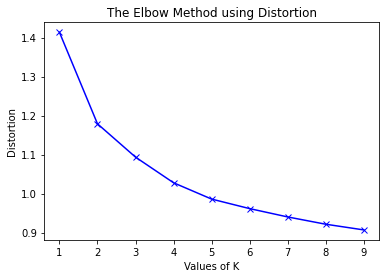

In [20]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

[Text(0.5, 0, 'src_area_b')]

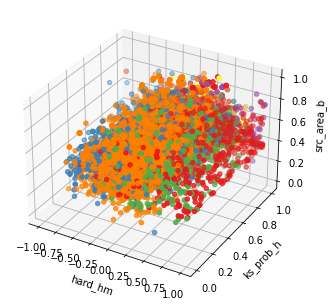

In [21]:
# %matplotlib notebook

colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("ks_prob_h")
colz = X_df.columns.get_loc("src_area_b")

colores=['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33'] # 6
markers=["o", "v", "1", "s", "X", "P"]
asignar=[]
for row in labels:
    asignar.append(colores[row])
    
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, colx], X[:, coly], X[:, colz], c=asignar,s=20)
ax.scatter(C[:, colx], C[:, coly], C[:, colz], marker='*', c=colores, s=1000)
ax.set(xlabel = X_df.columns[colx])
ax.set(ylabel = X_df.columns[coly])
ax.set(zlabel = X_df.columns[colz])

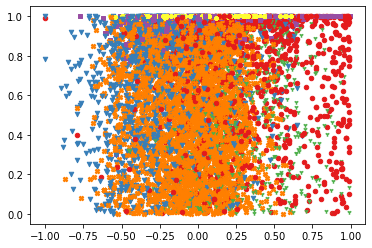

In [22]:
fig = plt.figure()
for i, row in enumerate(labels):
    plt.scatter(X[i, colx], X[i, coly], color=colores[row], marker=markers[row], s=20)
plt.show()

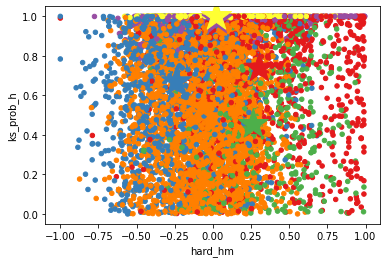

In [23]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("ks_prob_h")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

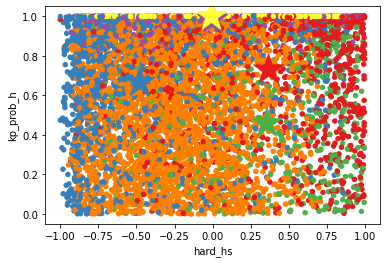

In [24]:
colx = X_df.columns.get_loc("hard_hs")
coly = X_df.columns.get_loc("kp_prob_h")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

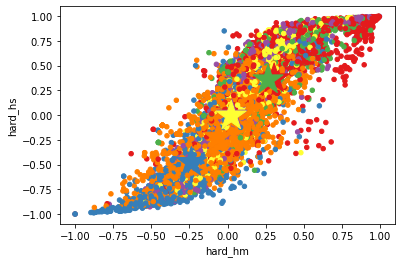

In [25]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("hard_hs")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

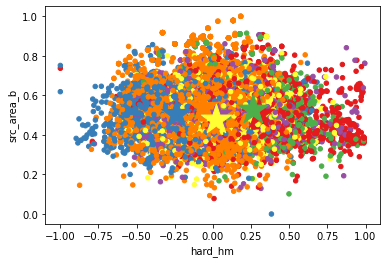

In [26]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("src_area_b")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

In [27]:
X_df_out_final = X_df_out.copy(deep=True)
X_df_out_final['cluster'] = labels

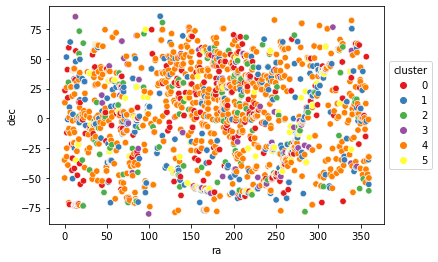

In [29]:
X_np_out=X_df_out_final.to_numpy()
colors = sns.color_palette()[0:6]

colx = X_df_out_final.columns.get_loc("ra")
coly = X_df_out_final.columns.get_loc("dec")
fig = plt.figure()
s = sns.scatterplot(data=X_df_out_final, x='ra', y='dec', hue=X_df_out_final["cluster"], palette=colores, s=40);
s.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title='cluster')
plt.xlabel(X_df_out_final.columns[colx]);
plt.ylabel(X_df_out_final.columns[coly]);
plt.show()

In [30]:
X_df_out_final.to_csv('cluster_data/clusterized_optixray_2mass.csv')